In [14]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import utils
import cmocean

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches


import string
alphabet = list(string.ascii_lowercase)
          

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

Data for this is from https://gmd.copernicus.org/articles/11/1133/2018/ CDRMIP data, where pi-CO2pulse is the 100GtC pulse and piControl is the control

In [2]:
G_pulse_ds = xr.open_dataset('Outputs/G_pulse_ds.nc4')['__xarray_dataarray_variable__']
G_cdr_ds = xr.open_dataset('Outputs/G_cdr_ds.nc4')['__xarray_dataarray_variable__']

#4th order polyfit
G_ds_path = 'Outputs/G_pulse_ds.nc4'
G_cdr_ds_path = 'Outputs/G_cdr_ds.nc4'

G_ds = utils.import_polyfit_G(G_ds_path, G_cdr_ds_path)

In [3]:
A = utils.A

In [4]:
model_color = utils.model_color

## Global Mean plots

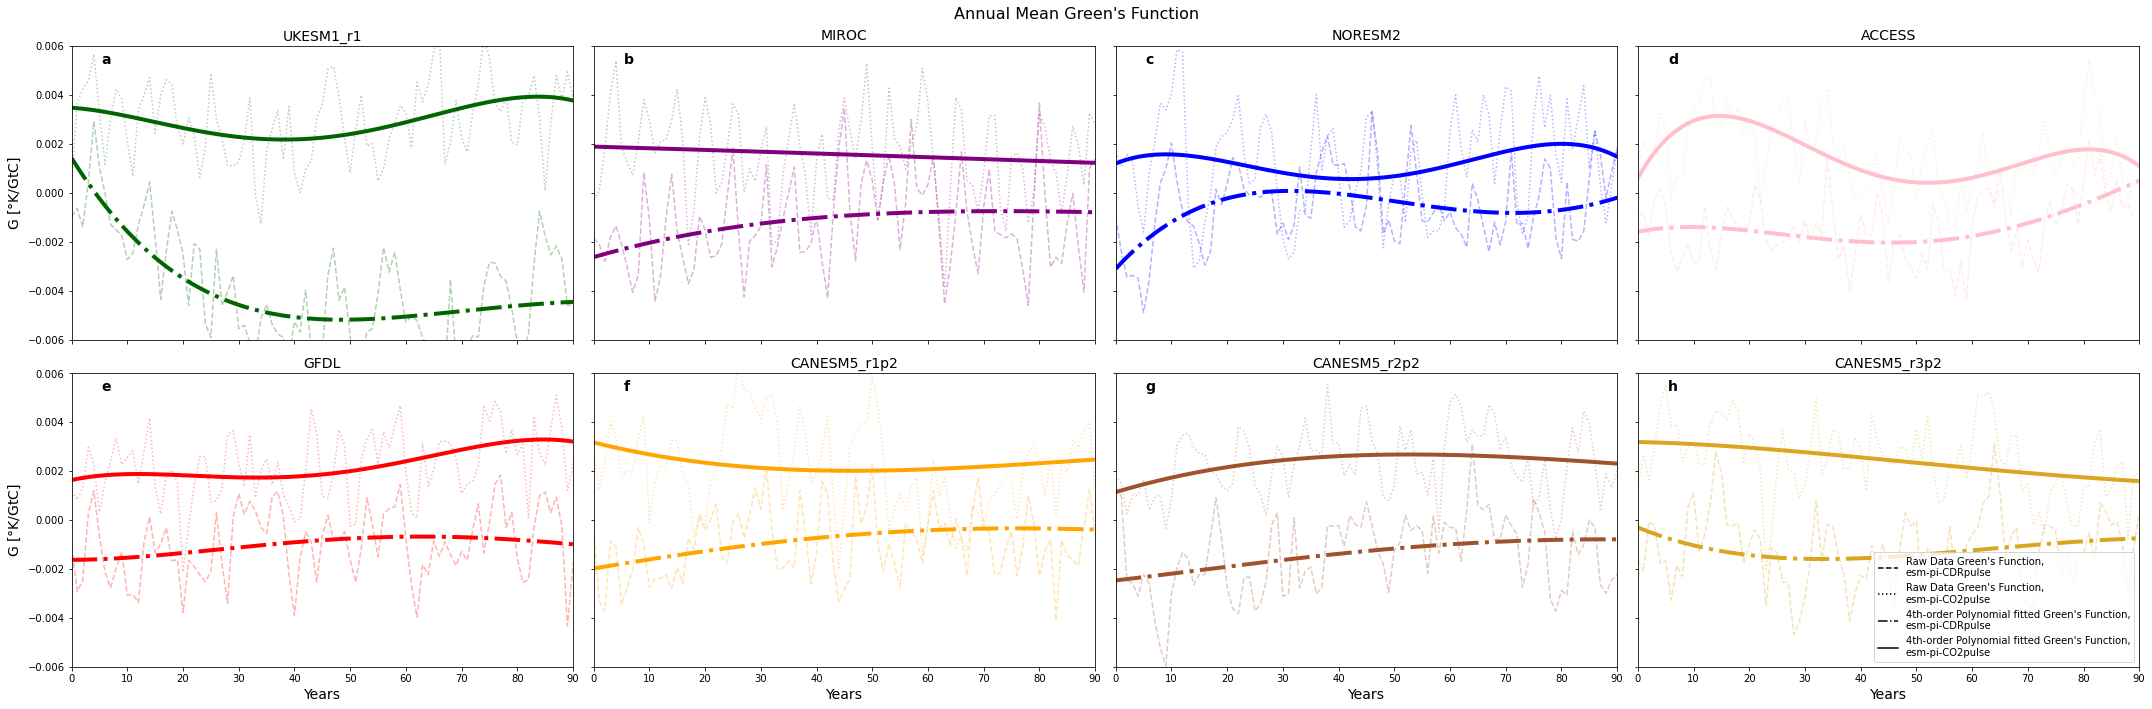

In [14]:
fig, axes = plt.subplots(2,4,figsize = [30,10], sharey = True, sharex = True)
alpha_labels = iter(alphabet)

plt.suptitle('Annual Mean Green\'s Function', fontsize = 16)
for ax, m in zip(axes.ravel(), G_ds.model.values):
    G_ds.sel(pulse_type = 'pulse').weighted(A).mean(dim = ['lat','lon']).sel(model = m).plot(ax = ax, color = model_color[m], linewidth = 4)
    (-G_ds).sel(pulse_type = 'cdr').weighted(A).mean(dim = ['lat','lon']).sel(model = m).plot(ax = ax, color = model_color[m], linestyle = '-.', linewidth = 4)
    (G_cdr_ds).weighted(A).mean(dim = ['lat','lon']).sel(model = m).plot(ax = ax, color = model_color[m], linestyle = '--', alpha = 0.3)
    G_pulse_ds.weighted(A).mean(dim = ['lat','lon']).sel(model = m).plot(ax = ax, color = model_color[m], linestyle = ':', alpha = 0.3)

    ax.set_xlim(0, 90)
    ax.set_title(m, fontsize = 14)
    ax.set_ylim(-0.006, 0.006)
    
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    label = next(alpha_labels)
    ax.text(x = .06, y =.94, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)
  
    
axes[0,0].set_ylabel('G [$\degree$K/GtC]', fontsize = 14)
axes[1,0].set_ylabel('G [$\degree$K/GtC]', fontsize = 14)
for idx in [0,1,2,3]:
    axes[1,idx].set_xlabel('Years', fontsize = 14)


####### legend ##########
raw_cdr = Line2D([0], [0], linestyle = '--', label='Raw Data Green\'s Function,\nesm-pi-CDRpulse', color='black')
raw_pulse = Line2D([0], [0], linestyle = ':', label='Raw Data Green\'s Function,\nesm-pi-CO2pulse', color='black') 
cdr = Line2D([0], [0], linestyle = '-.', label='4th-order Polynomial fitted Green\'s Function,\nesm-pi-CDRpulse', color='black')
pulse = Line2D([0], [0], label='4th-order Polynomial fitted Green\'s Function,\nesm-pi-CO2pulse', color='black')
handles = [raw_cdr, raw_pulse, cdr, pulse]
plt.legend(handles=handles)

plt.tight_layout()
plt.savefig('figures/paper/supplement/GF_mean_all_models.png', bbox_inches = 'tight', dpi = 300)

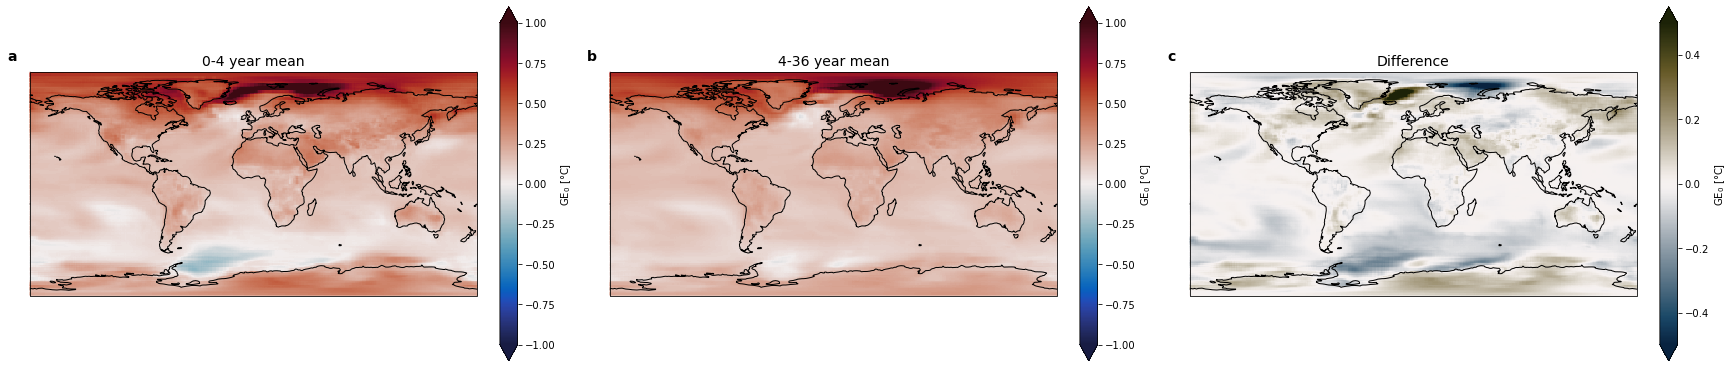

In [12]:
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = [24,5], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout=True)
alpha_labels = iter(alphabet)

(G_ds.mean(dim = ['model', 'pulse_type'])*100).isel(s = slice(0,4)).mean(dim = 's').plot(ax = ax0, vmax = 1, vmin = -1, transform = ccrs.PlateCarree(), extend = 'both', cmap = cmocean.cm.balance,
                                                       cbar_kwargs = {'label':'GE$_0$ [$\degree$C]'})
ax0.set_title('0-4 year mean', fontsize = 14)
ax0.coastlines()
(G_ds.mean(dim = ['model', 'pulse_type'])*100).isel(s = slice(4,36)).mean(dim = 's').plot(ax = ax1, vmax = 1, vmin = -1, transform = ccrs.PlateCarree(), extend = 'both', cmap = cmocean.cm.balance,
                                                       cbar_kwargs = {'label':'GE$_0$ [$\degree$C]'})
ax1.set_title('4-36 year mean', fontsize = 14)
ax1.coastlines()

((G_ds.mean(dim = ['model', 'pulse_type'])*100).isel(s = slice(0,4)).mean(dim = 's') - 
 (G_ds.mean(dim = ['model', 'pulse_type'])*100).isel(s = slice(4,36)).mean(dim = 's')).plot(ax = ax2, vmax = 0.5, vmin = -0.5, transform = ccrs.PlateCarree(), extend = 'both', cmap = cmocean.cm.diff,
                                                       cbar_kwargs = {'label':'GE$_0$ [$\degree$C]'})
ax2.set_title('Difference', fontsize = 14)
ax2.coastlines()

for ax in [ax0,ax1,ax2]:
    label = next(alpha_labels)
    ax.text(x = -0.05, y =1.05, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)

plt.savefig('figures/paper/supplement/GF_time_varying.png', bbox_inches = 'tight', dpi = 350)